In [10]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
import wandb

import torch
from torch import nn
from torchvision import models
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')
tile_set_name = 'train_tiles_2048_p25_test_v1'
tiles_dir = os.path.join(results_dir, tile_set_name)

# Load data
df = pd.read_csv(os.path.join(data_dir, train_csv))

In [54]:
import scipy

def split_crop(image, dir: str, th: int=0):
    if dir == 'h':
        labels, _ = scipy.ndimage.label(image.sum(axis=(0, 2)) > th)
    elif dir == 'v':
        labels, _ = scipy.ndimage.label(image.sum(axis=(1, 2)) > th)
    unique, counts = np.unique(labels, return_counts=True)
    counts = counts[unique!=0]
    unique = unique[unique!=0]
    larges_label = unique[np.argmax(counts)]
    if dir == 'h':
        image = image[:, labels==larges_label, :]
    elif dir == 'v':
        image = image[labels==larges_label, :, :]
    return image

def smart_crop(image):
    image = np.array(image)

    # Iterative split and crop
    image = split_crop(image, 'h')
    image = split_crop(image, 'v')
    image = split_crop(image, 'h')
    image = split_crop(image, 'v')

    black_bg = np.sum(image, axis=2) == 0
    image[black_bg, :] = 255

    return Image.fromarray(image)

NameError: name 'smart_crop' is not defined

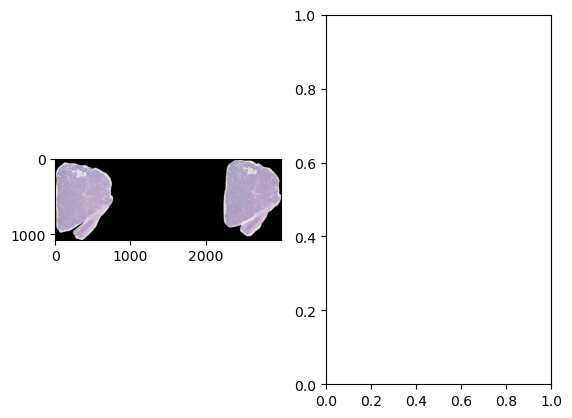

In [11]:
image_id_list = ['44804', '60685', '34845', '20858', '5251', '60685', '63289', '4', '66']

for image_id in image_id_list:
    image = Image.open(os.path.join(train_thumbnail_dir, image_id+'_thumbnail.png'))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(smart_crop(image))

In [ ]:
model = models.get_model('efficientnet_b0', weights='DEFAULT').to(device)
model.classifier

In [ ]:
model = models.get_model('vit_b_16', weights='DEFAULT').to(device)
model.heads.head

In [ ]:
model = models.get_model('resnet34', weights='DEFAULT').to(device)
model.fc

In [52]:
import torch
from torch import nn
from timm import create_model
import numpy as np

class Flatten(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x): 
        input_shape = x.shape
        print(input_shape)
        output_shape = [input_shape[i] for i in range(self.dim)] + [-1]
        return x.view(*output_shape)
    
class SimpleMIL(nn.Module):

    def __init__(self, model_name, num_instances, num_classes, pretrained=True):
        super().__init__()

        self.num_instances = num_instances
        self.encoder = create_model(model_name, pretrained=pretrained, num_classes=num_classes)
        feature_dim = self.encoder.get_classifier().in_features
        self.head = nn.Sequential(
            nn.AdaptiveMaxPool2d(1), Flatten(),
            nn.Linear(feature_dim, 256), nn.ReLU(inplace=True), 
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x: bs x N x C x W x W
        bs, _, ch, w, h = x.shape
        x = x.view(bs*self.num_instances, ch, w, h) # x: N bs x C x W x W
        x = self.encoder.forward_features(x) # x: N bs x C' x W' x W'

        # Concat and pool
        bs2, ch2, w2, h2 = x.shape
        x = x.view(-1, self.num_instances, ch2, w2, h2).permute(0, 2, 1, 3, 4)\
            .contiguous().view(bs, ch2, self.num_instances*w2, h2) # x: bs x C' x N W'' x W''
        print(x.shape)
        x = self.head(x)

        return x

s = 224
m = SimpleMIL('resnet34', 4, 5, s)
data = torch.Tensor(np.random.rand(s,s,3)).permute(2,0,1).expand((3, 4, 3, s, s))
m(data)

torch.Size([3, 512, 28, 7])
torch.Size([3, 512, 1, 1])


tensor([[ 0.3038,  1.9379,  1.4601, -0.6577,  1.0864],
        [ 0.3038,  1.9379,  1.4601, -0.6577,  1.0864],
        [ 0.3038,  1.9379,  1.4601, -0.6577,  1.0864]],
       grad_fn=<AddmmBackward0>)

In [49]:
m.encoder.get_classifier().in_features

512